# **LOAN DEFAULT**


### **Running PySpark in Google CoLab.**


In [26]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
# !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
# !tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
# !pip install -q findspark

# Mount Google Drive to access your files
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your Spark archive on Google Drive
spark_archive_path = '/content/drive/MyDrive/spark/spark-3.4.1-bin-hadoop3.tgz'

# Copy the Spark archive from Google Drive to your Colab environment
!cp "$spark_archive_path" .

# Extract the Spark archive
!tar xf spark-3.4.1-bin-hadoop3.tgz

# Set your Spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Install findspark using pip
!pip install -q findspark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Initialize a Spark Session using PySpark**


In [27]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LoanDefault").master("local[*]").getOrCreate()

In [28]:
# Check the version of Apache Spark that we have initialized in our PySpark session
spark.version

'3.4.1'

### **Access the underlying SparkContext**

In [29]:
# Access the underlying SparkContext
from pyspark import SparkContext

sc = spark.sparkContext
print("Application name assigned to the SparkContext 'sc': ",sc.appName,"\n")

# To get the information about the SparkContext object in PySpark
print("Info about sparkContext: ", spark.sparkContext,"\n")

# To get the Spark application name
print("Spark App Name : "+ spark.sparkContext.appName)

Application name assigned to the SparkContext 'sc':  LoanDefault 

Info about sparkContext:  <SparkContext master=local[*] appName=LoanDefault> 

Spark App Name : LoanDefault


In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

### **Load the dataset**

In [31]:
# Load the dataset
df = spark.read.csv("/content/drive/MyDrive/Data/loan_default.csv",header=True, inferSchema= True)

### **A glimpse of the dataset**

In [32]:
# A glimpse of the dataset
df.show(5)

+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|        Yes|          Yes|      Other|        Yes|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|         No|           N

### **Understanding the Dataset**

In [33]:
# Basic information about the dataset
print("Number of rows (observations):", df.count())
print("Number of columns (attributes):", len(df.columns))
print("Column names:", df.columns, "\n")

# Summary statistics
# df.describe().show()

from pyspark.sql.functions import col, round

# Calculate summary statistics
summary_stats = df.describe()

# Iterate through each column and round the statistics to 2 decimal points
for column_name in df.columns:
    summary_stats = summary_stats.withColumn(column_name, round(col(column_name), 2))

# Show the summary statistics rounded to 2 decimal points"
print("\nSummary Statistics:\n")
summary_stats.show()

Number of rows (observations): 255347
Number of columns (attributes): 18
Column names: ['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default'] 


Summary Statistics:

+-------+--------+--------+--------+----------+-----------+--------------+--------------+------------+--------+--------+---------+--------------+-------------+-----------+-------------+-----------+-----------+--------+
|summary|  LoanID|     Age|  Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner| Default|
+-------+--------+--------+--------+----------+-----------+--------------+--------------+------------+--------+--------+---------+--------------+-------------+-----------+-------------+-----------+

In [34]:
# Display the schema and sample data
df.printSchema()

root
 |-- LoanID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- MonthsEmployed: integer (nullable = true)
 |-- NumCreditLines: integer (nullable = true)
 |-- InterestRate: double (nullable = true)
 |-- LoanTerm: integer (nullable = true)
 |-- DTIRatio: double (nullable = true)
 |-- Education: string (nullable = true)
 |-- EmploymentType: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- HasMortgage: string (nullable = true)
 |-- HasDependents: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- HasCoSigner: string (nullable = true)
 |-- Default: integer (nullable = true)



In [35]:
# Check for duplicate rows
unique_df = df.dropDuplicates()

# Compare counts
if df.count() != unique_df.count():
    print("Duplicate rows found.")
else:
    print("No duplicate rows.")

No duplicate rows.


In [36]:
# Check for missing values including NaN, blank, and null
from pyspark.sql.functions import isnan, isnull, when

missing_data = df.agg(*[
    F.sum(when(isnull(c) | isnan(c) | (F.col(c) == ""), 1).otherwise(0)).alias(c + "_NA")
    for c in df.columns
])

# Show the missing value counts for each column
missing_data.show()

+---------+------+---------+-------------+--------------+-----------------+-----------------+---------------+-----------+-----------+------------+-----------------+----------------+--------------+----------------+--------------+--------------+----------+
|LoanID_NA|Age_NA|Income_NA|LoanAmount_NA|CreditScore_NA|MonthsEmployed_NA|NumCreditLines_NA|InterestRate_NA|LoanTerm_NA|DTIRatio_NA|Education_NA|EmploymentType_NA|MaritalStatus_NA|HasMortgage_NA|HasDependents_NA|LoanPurpose_NA|HasCoSigner_NA|Default_NA|
+---------+------+---------+-------------+--------------+-----------------+-----------------+---------------+-----------+-----------+------------+-----------------+----------------+--------------+----------------+--------------+--------------+----------+
|        0|     0|        0|            0|             0|                0|                0|              0|          0|          0|           0|                0|               0|             0|               0|             0|       

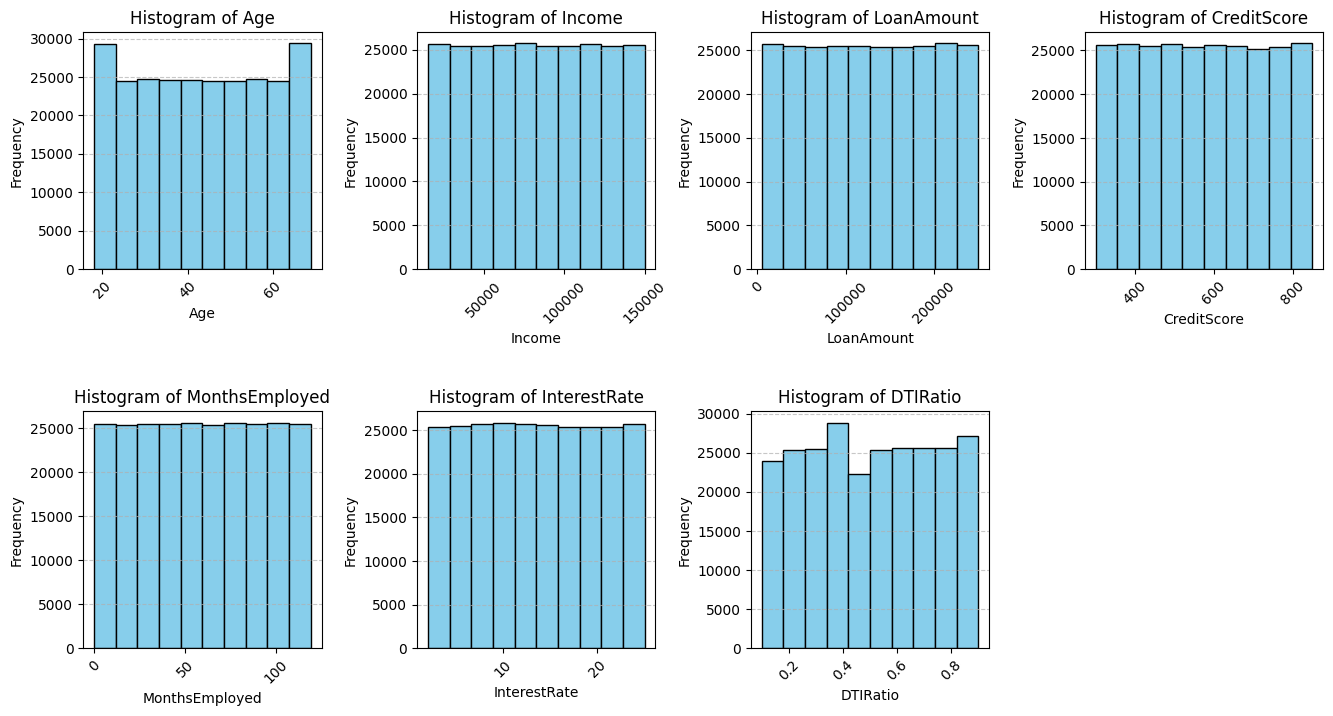

In [37]:
# Histograms
import matplotlib.pyplot as plt
import pandas as pd

# Select the columns you want to create histograms for
selected_columns = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'InterestRate', 'DTIRatio']

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df.select(selected_columns).toPandas()

# Create a 2x4 grid of subplots, and remove the last empty subplot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
fig.subplots_adjust(hspace=0.6, wspace=0.4)  # Increase hspace and wspace

# Create histograms for each selected column and arrange them in the subplots
for i, column in enumerate(selected_columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    ax.hist(df_pandas[column], bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Slant the x-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove the last empty subplot
fig.delaxes(axes[1, 3])

# Display the subplots
plt.show()

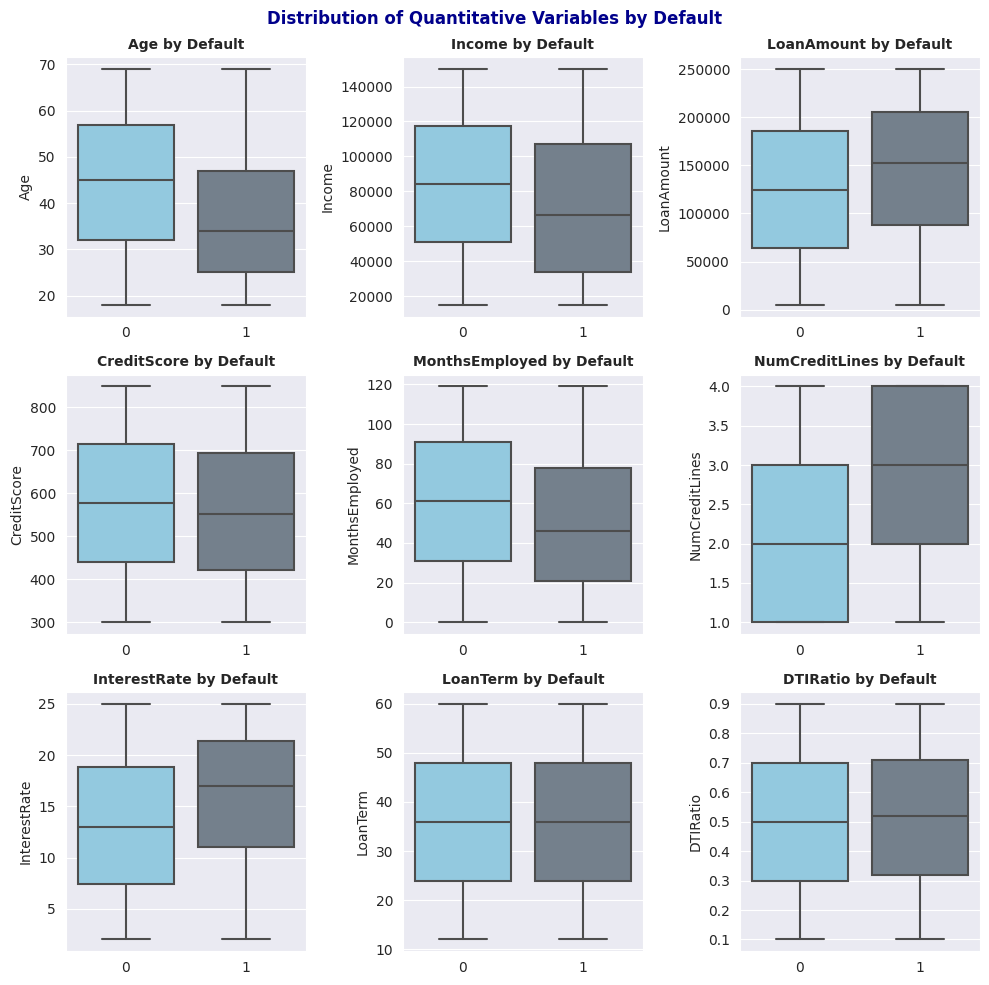

In [38]:
# Check for outliers
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col

# Select the quantitative columns and "Default" column
quantitative_columns = [col for col, data_type in df.dtypes if data_type in ["int", "double"]]
quantitative_columns.remove("Default")  # Exclude the "Default" column
data = df.select(quantitative_columns + ["Default"]).toPandas()

# Create box plots for quantitative variables by "Default"
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
axes = axes.flat

palette = {0: "skyblue", 1: "slategrey"}

for i, col in enumerate(quantitative_columns):
    sns.boxplot(data=data, x="Default", y=col, ax=axes[i], palette=palette)
    axes[i].set_title(f"{col} by Default", fontsize=10, fontweight="bold")
    axes[i].set_xlabel("")

fig.suptitle("Distribution of Quantitative Variables by Default", fontsize=12, fontweight="bold", color="darkblue")
fig.tight_layout()
plt.show()

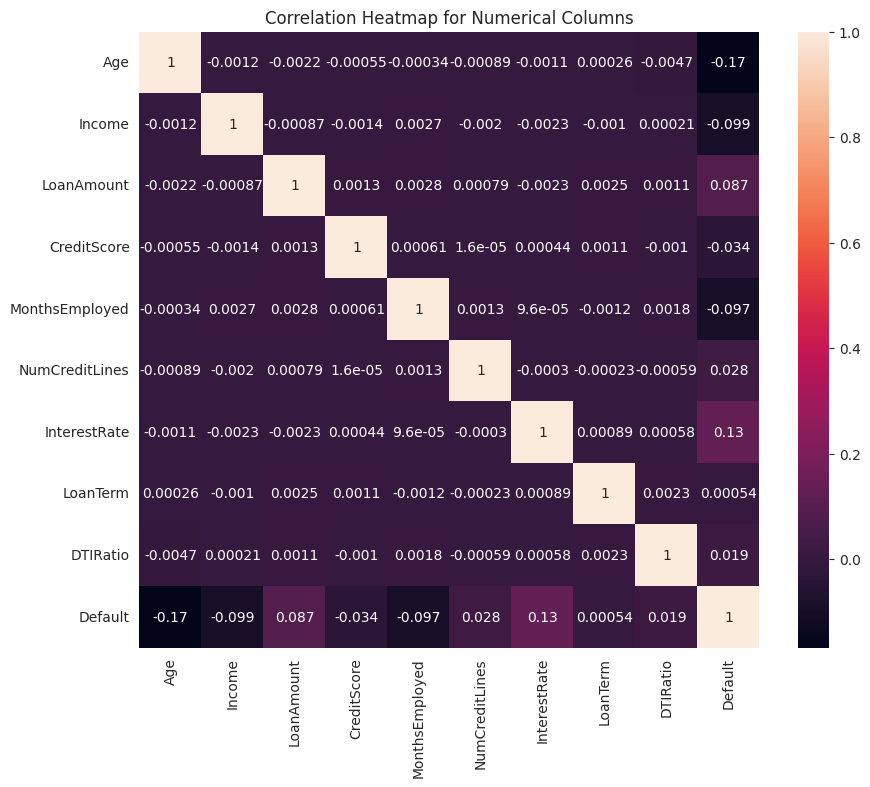

In [39]:
# Correlation Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col

# Select numerical columns (excluding non-numeric columns)
numerical_columns = [col for col, data_type in df.dtypes if data_type in ["int", "double"]]

# Calculate the correlation matrix
correlation_matrix = df.select(numerical_columns).toPandas().corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Heatmap for Numerical Columns")
plt.show()


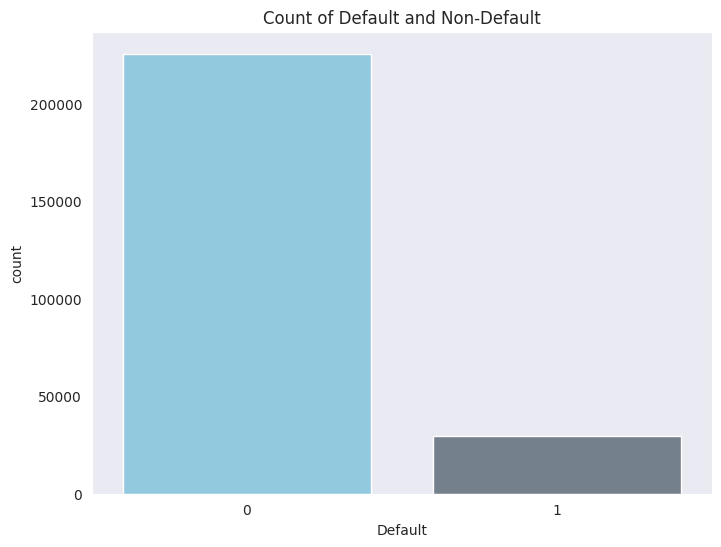

In [40]:
# Count of Default and Non-Default
# Convert the "Default" column to string
data = df.withColumn("Default", df["Default"].cast("string"))

# Create a count plot using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=data.toPandas(), x="Default", palette={"0": "skyblue", "1": "slategrey"})

# Set the title for the plot
plt.title("Count of Default and Non-Default")

# Show the plot
plt.grid(False)
plt.show()


### **Balancing the Data - with Undersampling**

In [41]:
# Calculate the count of each class in the "Default" column
class_counts = df.groupBy("Default").count()

# Find the minority class label
minority_class = class_counts.orderBy(col("count").asc()).first()["Default"]

# Calculate the count of the minority class
minority_count = class_counts.filter(col("Default") == minority_class).first()["count"]

# Calculate the count of the majority class
majority_count = class_counts.filter(col("Default") != minority_class).first()["count"]

# Determine the undersampling ratio
undersampling_ratio = minority_count / majority_count

# Perform undersampling using the sample function
undersampled_df = df.filter(col("Default") == minority_class).union(
    df.filter(col("Default") != minority_class).sample(withReplacement=False, fraction=undersampling_ratio, seed=42)
)

# Show the resulting undersampled DataFrame
undersampled_df.count()

59474

In [42]:
df = undersampled_df
df.count()

59474

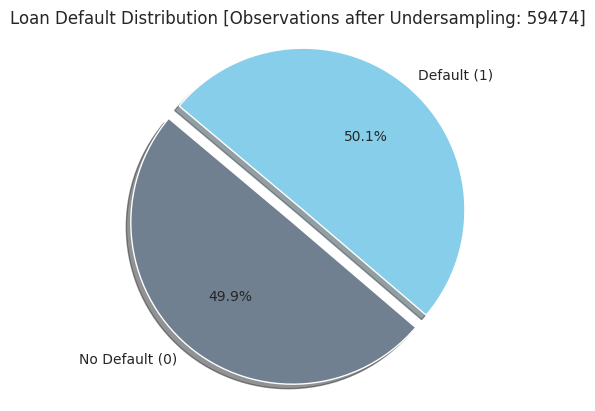

In [43]:
import matplotlib.pyplot as plt

row_count = df.count()

# Calculate the percentage of defaults
default_counts = df.groupBy("Default").count()
default_percentages = default_counts.withColumn(
    "Percentage", (default_counts["count"] / row_count) * 100
)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
default_percentages = default_percentages.toPandas()

# Create the pie chart
labels = ["No Default (0)", "Default (1)"]
sizes = default_percentages["Percentage"]
colors = ["slategrey", "skyblue"]
explode = (0.1, 0)  # Explode the "No Default" slice for emphasis

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Loan Default Distribution [Observations after Undersampling: {0}]".format(row_count))
plt.show()

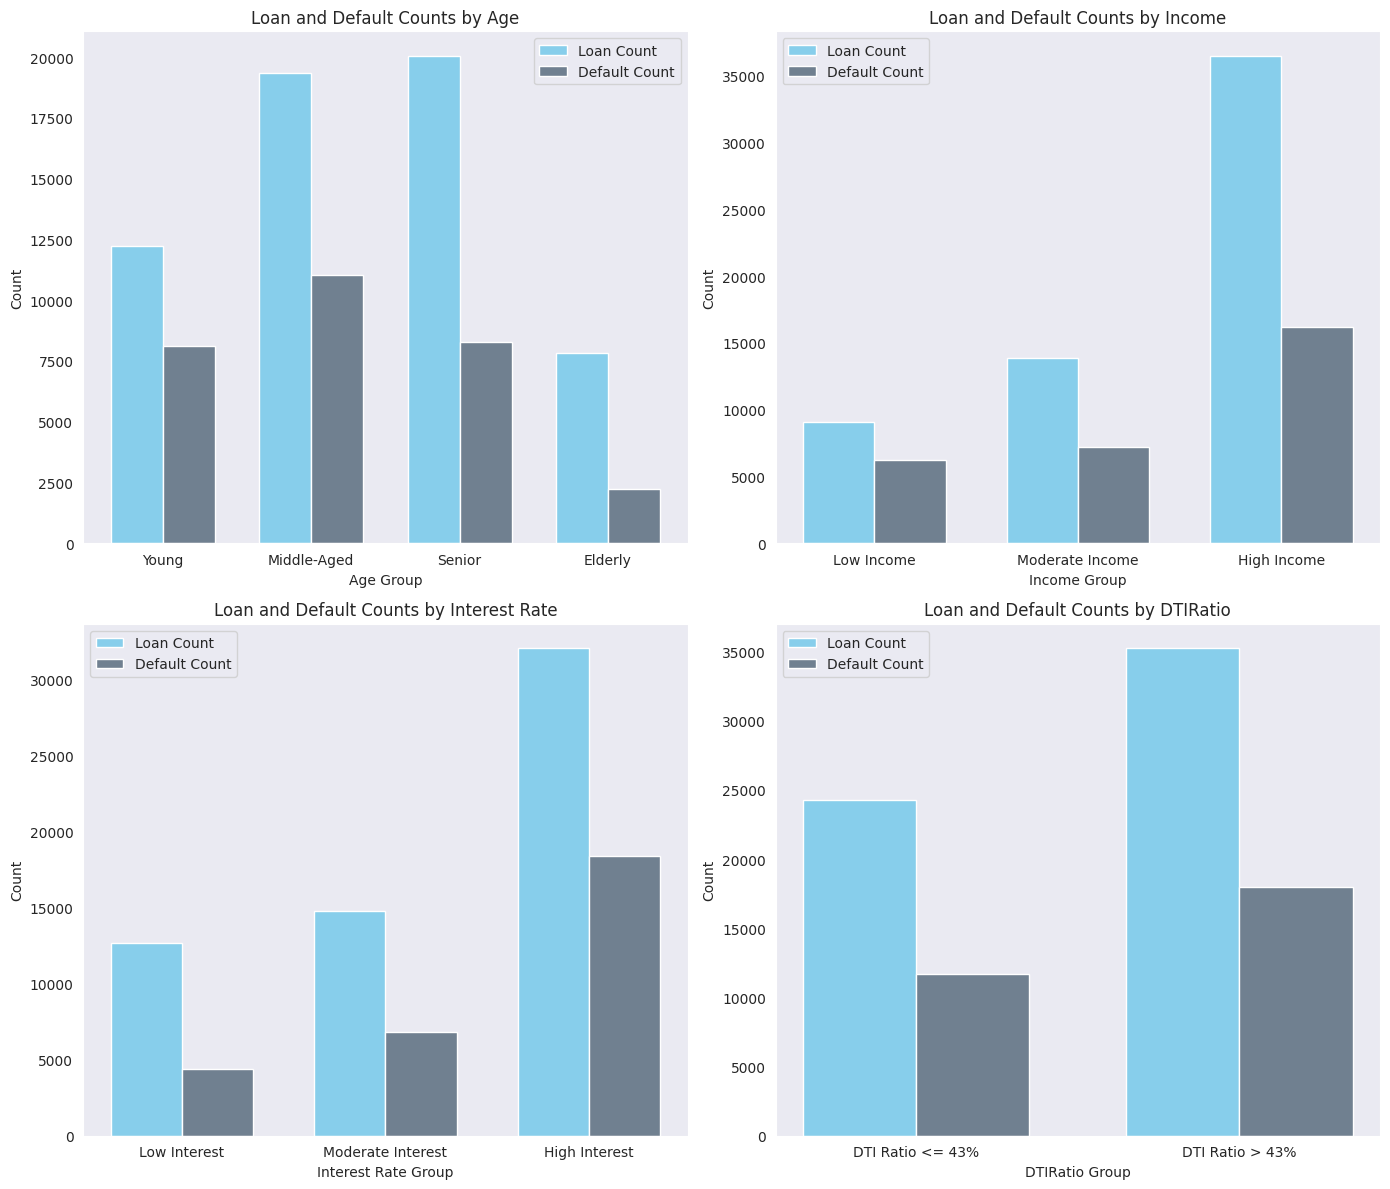

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the age bins and labels
age_bins = [0, 25, 40, 60, float("inf")]
age_labels = ['Young', 'Middle-Aged', 'Senior', 'Elderly']

# Create a new column 'AgeGroup' in the PySpark DataFrame
from pyspark.sql.functions import when, col

df = df.withColumn('AgeGroup',
                   when(col('Age') <= 25, 'Young')
                   .when((col('Age') > 25) & (col('Age') <= 40), 'Middle-Aged')
                   .when((col('Age') > 40) & (col('Age') <= 60), 'Senior')
                   .otherwise('Elderly'))

# Group the data by 'AgeGroup' and calculate the number of defaults and loan count in each group
age_group_counts = df.groupBy('AgeGroup').agg({'Default': 'sum', 'LoanID': 'count'})
age_group_counts = age_group_counts.withColumnRenamed('sum(Default)', 'DefaultCount')
age_group_counts = age_group_counts.withColumnRenamed('count(LoanID)', 'LoanCount')

# Define the desired order of age groups
desired_order = ['Young', 'Middle-Aged', 'Senior', 'Elderly']

# Convert the result to a Pandas DataFrame for visualization
age_group_counts_pandas = age_group_counts.toPandas()
age_group_counts_pandas['AgeGroup'] = pd.Categorical(age_group_counts_pandas['AgeGroup'], categories=desired_order, ordered=True)
age_group_counts_pandas = age_group_counts_pandas.sort_values('AgeGroup')

# Create a grouped bar graph to show defaults and loan count within each age group with the desired order
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

bar_width = 0.35
index = range(len(age_group_counts_pandas['AgeGroup']))
axes[0, 0].bar(index, age_group_counts_pandas['LoanCount'], bar_width, label='Loan Count', color='skyblue')
axes[0, 0].bar([i + bar_width for i in index], age_group_counts_pandas['DefaultCount'], bar_width, label='Default Count', color='slategrey')
axes[0, 0].set_title('Loan and Default Counts by Age')
axes[0, 0].set_xlabel('Age Group')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([i + bar_width / 2 for i in index])
axes[0, 0].set_xticklabels(age_group_counts_pandas['AgeGroup'])
axes[0, 0].legend()
axes[0, 0].grid(False)

# Define the income bins and labels
income_bins = [0, 30000, 60000, float("inf")]
income_labels = ['Low Income', 'Moderate Income', 'High Income']

# Create a new column 'IncomeGroup' in the PySpark DataFrame
df = df.withColumn('IncomeGroup',
                   when(col('Income') <= 30000, 'Low Income')
                   .when((col('Income') > 30000) & (col('Income') <= 60000), 'Moderate Income')
                   .otherwise('High Income'))

# Group the data by 'IncomeGroup' and calculate the number of defaults and loan count in each group
income_group_counts = df.groupBy('IncomeGroup').agg({'Default': 'sum', 'LoanID': 'count'})
income_group_counts = income_group_counts.withColumnRenamed('sum(Default)', 'DefaultCount')
income_group_counts = income_group_counts.withColumnRenamed('count(LoanID)', 'LoanCount')

# Define the desired order of income groups
desired_order = ['Low Income', 'Moderate Income', 'High Income']

# Convert the result to a Pandas DataFrame for visualization
income_group_counts_pandas = income_group_counts.toPandas()
income_group_counts_pandas['IncomeGroup'] = pd.Categorical(income_group_counts_pandas['IncomeGroup'], categories=desired_order, ordered=True)
income_group_counts_pandas = income_group_counts_pandas.sort_values('IncomeGroup')

# Create a grouped bar graph to show defaults and loan count within each income group with the desired order
bar_width = 0.35
index = range(len(income_group_counts_pandas['IncomeGroup']))
axes[0, 1].bar(index, income_group_counts_pandas['LoanCount'], bar_width, label='Loan Count', color='skyblue')
axes[0, 1].bar([i + bar_width for i in index], income_group_counts_pandas['DefaultCount'], bar_width, label='Default Count', color='slategrey')
axes[0, 1].set_title('Loan and Default Counts by Income')
axes[0, 1].set_xlabel('Income Group')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xticks([i + bar_width / 2 for i in index])
axes[0, 1].set_xticklabels(income_group_counts_pandas['IncomeGroup'])
axes[0, 1].legend()
axes[0, 1].grid(False)

# Define the interest rate bins and labels
interest_rate_bins = [0, 8, 15, float("inf")]
interest_rate_labels = ['Low Interest', 'Moderate Interest', 'High Interest']

# Create a new column 'InterestRateGroup' in the PySpark DataFrame
df = df.withColumn('InterestRateGroup',
                   when((col('InterestRate') >= 0) & (col('InterestRate') <= 8), 'Low Interest')
                   .when((col('InterestRate') > 9) & (col('InterestRate') <= 15), 'Moderate Interest')
                   .otherwise('High Interest'))

# Group the data by 'InterestRateGroup' and calculate the number of defaults and loan count in each group
interest_rate_group_counts = df.groupBy('InterestRateGroup').agg({'Default': 'sum', 'LoanID': 'count'})
interest_rate_group_counts = interest_rate_group_counts.withColumnRenamed('sum(Default)', 'DefaultCount')
interest_rate_group_counts = interest_rate_group_counts.withColumnRenamed('count(LoanID)', 'LoanCount')

# Define the desired order of interest rate groups
desired_order = ['Low Interest', 'Moderate Interest', 'High Interest']

# Convert the result to a Pandas DataFrame for visualization
interest_rate_group_counts_pandas = interest_rate_group_counts.toPandas()
interest_rate_group_counts_pandas['InterestRateGroup'] = pd.Categorical(interest_rate_group_counts_pandas['InterestRateGroup'], categories=desired_order, ordered=True)
interest_rate_group_counts_pandas = interest_rate_group_counts_pandas.sort_values('InterestRateGroup')

# Create a grouped bar graph to show defaults and loan count within each interest rate group with the desired order
bar_width = 0.35
index = range(len(interest_rate_group_counts_pandas['InterestRateGroup']))
axes[1, 0].bar(index, interest_rate_group_counts_pandas['LoanCount'], bar_width, label='Loan Count', color='skyblue')
axes[1, 0].bar([i + bar_width for i in index], interest_rate_group_counts_pandas['DefaultCount'], bar_width, label='Default Count', color='slategrey')
axes[1, 0].set_title('Loan and Default Counts by Interest Rate')
axes[1, 0].set_xlabel('Interest Rate Group')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks([i + bar_width / 2 for i in index])
axes[1, 0].set_xticklabels(interest_rate_group_counts_pandas['InterestRateGroup'])
axes[1, 0].legend()
axes[1, 0].grid(False)

# Define the DTIRatio bins and labels
dti_ratio_bins = [0, 0.43, float("inf")]
dti_ratio_labels = ['DTI Ratio <= 43%', 'DTI Ratio > 43%']

# Create a new column 'DTIRatioGroup' in the PySpark DataFrame
df = df.withColumn('DTIRatioGroup',
                   when((col('DTIRatio') >= 0) & (col('DTIRatio') <= 0.43), 'DTI Ratio <= 43%')
                   .otherwise('DTI Ratio > 43%'))

# Group the data by 'DTIRatioGroup' and calculate the number of defaults and loan count in each group
dti_ratio_group_counts = df.groupBy('DTIRatioGroup').agg({'Default': 'sum', 'LoanID': 'count'})
dti_ratio_group_counts = dti_ratio_group_counts.withColumnRenamed('sum(Default)', 'DefaultCount')
dti_ratio_group_counts = dti_ratio_group_counts.withColumnRenamed('count(LoanID)', 'LoanCount')

# Define the desired order of DTIRatio groups
desired_order = ['DTI Ratio <= 43%', 'DTI Ratio > 43%']

# Convert the result to a Pandas DataFrame for visualization
dti_ratio_group_counts_pandas = dti_ratio_group_counts.toPandas()
dti_ratio_group_counts_pandas['DTIRatioGroup'] = pd.Categorical(dti_ratio_group_counts_pandas['DTIRatioGroup'], categories=desired_order, ordered=True)
dti_ratio_group_counts_pandas = dti_ratio_group_counts_pandas.sort_values('DTIRatioGroup')

# Create a grouped bar graph to show defaults and loan count within each DTIRatio group with the desired order
bar_width = 0.35
index = range(len(dti_ratio_group_counts_pandas['DTIRatioGroup']))
axes[1, 1].bar(index, dti_ratio_group_counts_pandas['LoanCount'], bar_width, label='Loan Count', color='skyblue')
axes[1, 1].bar([i + bar_width for i in index], dti_ratio_group_counts_pandas['DefaultCount'], bar_width, label='Default Count', color='slategrey')
axes[1, 1].set_title('Loan and Default Counts by DTIRatio')
axes[1, 1].set_xlabel('DTIRatio Group')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticks([i + bar_width / 2 for i in index])
axes[1, 1].set_xticklabels(dti_ratio_group_counts_pandas['DTIRatioGroup'])
axes[1, 1].legend()
axes[1, 1].grid(False)

plt.tight_layout()
plt.show()

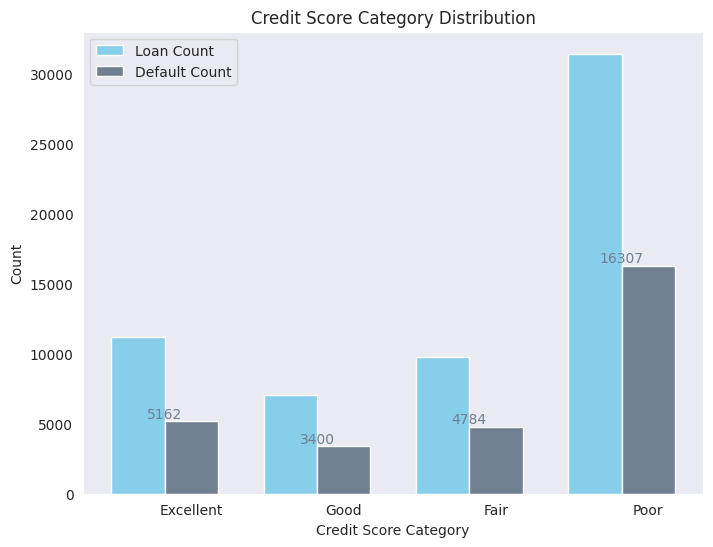

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import when, col

# Define the credit score categories
credit_score_bins = [0, 580, 670, 740, float("inf")]
credit_score_labels = ['Poor', 'Fair', 'Good', 'Excellent']

# Create a new column 'CreditScoreCategory' in the PySpark DataFrame
df = df.withColumn('CreditScoreCategory',
                   when((col('CreditScore') >= 0) & (col('CreditScore') <= 580), 'Poor')
                   .when((col('CreditScore') > 580) & (col('CreditScore') <= 670), 'Fair')
                   .when((col('CreditScore') > 670) & (col('CreditScore') <= 740), 'Good')
                   .otherwise('Excellent'))

# Group the data by 'CreditScoreCategory' and calculate the number of data points and defaults in each category
credit_score_group_counts = df.groupBy('CreditScoreCategory').agg({'LoanID': 'count', 'Default': 'sum'})
credit_score_group_counts = credit_score_group_counts.withColumnRenamed('count(LoanID)', 'Count')
credit_score_group_counts = credit_score_group_counts.withColumnRenamed('sum(Default)', 'DefaultCount')

# Convert the result to a Pandas DataFrame for visualization
credit_score_group_counts_pandas = credit_score_group_counts.toPandas()

# Create a bar plot to show the distribution of credit score categories with counts
plt.figure(figsize=(8, 6))
width = 0.35
index = range(len(credit_score_group_counts_pandas['CreditScoreCategory']))
bar1 = plt.bar(index, credit_score_group_counts_pandas['Count'], width, color='skyblue', label='Loan Count')
bar2 = plt.bar([i + width for i in index], credit_score_group_counts_pandas['DefaultCount'], width, color='slategrey', label='Default Count')

plt.title('Credit Score Category Distribution')
plt.xlabel('Credit Score Category')
plt.ylabel('Count')
plt.xticks([i + width for i in index], credit_score_group_counts_pandas['CreditScoreCategory'])

# Add text labels for default counts on top of the bars
for i, count in enumerate(credit_score_group_counts_pandas['DefaultCount']):
    plt.text(index[i] + width / 2, count, str(count), ha='center', va='bottom', color='slategrey')

# Add separate legends for Total Count and Default Count
plt.legend(handles=[bar1, bar2])
plt.grid(False)
plt.show()

In [46]:
# Drop unnecessary columns
df = df.drop("LoanID")

In [47]:
# Split the data into training and testing sets
(trainingData, testingData) = df.randomSplit([0.7, 0.3], seed=10)

### **Data Preprocessing and Data Pipeline**

In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler, OneHotEncoder

# Define lists of numerical and categorical columns
numerical_columns = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]
categorical_columns = ["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]

# Create transformers for preprocessing
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_columns]
encoder = OneHotEncoder(inputCols=[col + "_index" for col in categorical_columns], outputCols=[col + "_onehot" for col in categorical_columns])
assembler = VectorAssembler(inputCols=numerical_columns + [col + "_onehot" for col in categorical_columns], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Create a preprocessing pipeline
pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler])

# Fit and transform the pipeline on the training data
pipeline_model = pipeline.fit(trainingData)
train_data = pipeline_model.transform(trainingData)

# Transform the test data using the same pipeline
test_data = pipeline_model.transform(testingData)

In [49]:
print(f"Number of rows in final training data: {train_data.count()}")
print(f"Number of rows in final testing data: {test_data.count()}")

Number of rows in final training data: 41616
Number of rows in final testing data: 17858


## **Logistic Regression**

In [50]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create a Logistic Regression model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Default", maxIter=10)

# Fit the model to the training data
lr_model = lr.fit(train_data)

# Make predictions on the training data
train_predictions = lr_model.transform(train_data)  # Predictions for the training data

# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction")

# Calculate the AUC-ROC on the training data
areaUnderROC_train = evaluator.evaluate(train_predictions)

# Print the AUC-ROC value for the training data
print("Area Under ROC Curve (AUC-ROC) for Training Data: {:.2f}".format(areaUnderROC_train))

Area Under ROC Curve (AUC-ROC) for Training Data: 0.75


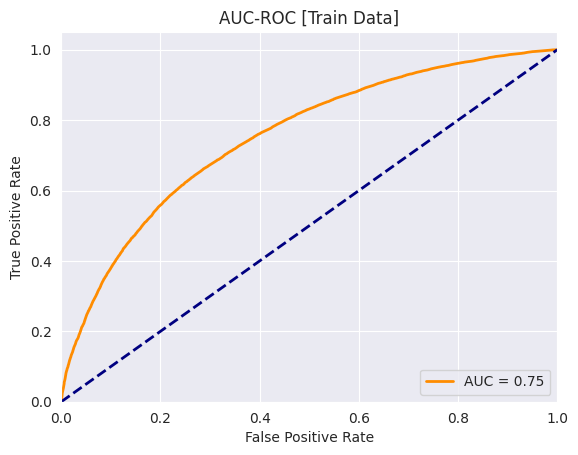

In [51]:
# Get the ROC curve
roc = lr_model.summary.roc.toPandas()

# Plot the ROC curve with AUC in the label
import matplotlib.pyplot as plt
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label=f'AUC = {areaUnderROC_train:.2f}')  # Use areaUnderROC here
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC [Train Data]')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [52]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Create a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction")

# Calculate the AUC-ROC on the test data
areaUnderROC = evaluator.evaluate(predictions)

# Print the AUC-ROC value
print("Area Under ROC Curve (AUC-ROC): {:.2f}".format(areaUnderROC))

Area Under ROC Curve (AUC-ROC): 0.74


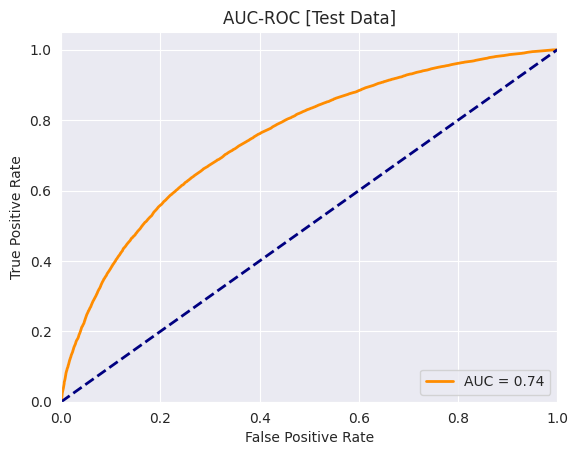

In [53]:
# Get the ROC curve
roc = lr_model.summary.roc.toPandas()

# Plot the ROC curve with AUC in the label
import matplotlib.pyplot as plt
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label=f'AUC = {areaUnderROC:.2f}')  # Use areaUnderROC here
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC [Test Data]')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

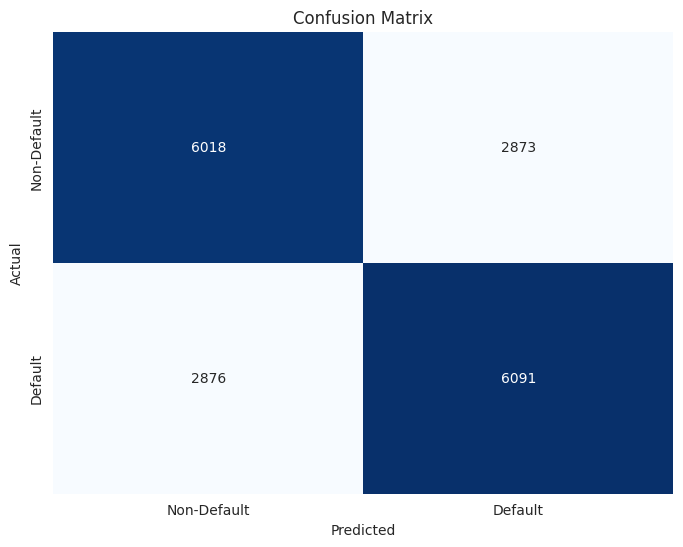


Accuracy: 0.68

Precision: 0.68

Recall: 0.68

F1-Score: 0.68


In [54]:
# Evaluate the model

from sklearn.metrics import confusion_matrix
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
y_true = predictions.select("Default").rdd.flatMap(lambda x: x)
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x)
confusion_matrix = confusion_matrix(y_true.collect(), y_pred.collect())

# Add row and column names to the confusion matrix
class_names = ['Non-Default', 'Default']
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

"""
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix_df)
"""

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Default", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy, precision, recall,and F1-score
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

"""
print("\nAccuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1_score)
"""
print(f"\nAccuracy: {accuracy:.2f}")
print(f"\nPrecision: {precision:.2f}")
print(f"\nRecall: {recall:.2f}")
print(f"\nF1-Score: {f1_score:.2f}")


### **Random Forest Classifier**

In [55]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Create a Random Forest model
rf = RandomForestClassifier(labelCol="Default", featuresCol="scaled_features", numTrees=100)

# Fit the model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the training data
train_predictions = rf_model.transform(train_data)

# Calculate the AUC-ROC for the training data
evaluator = BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
areaUnderROC_train = evaluator.evaluate(train_predictions)

# Print the AUC-ROC value for training data
print("Area Under ROC Curve (AUC-ROC) for Training Data: {:.2f}".format(areaUnderROC_train))

Area Under ROC Curve (AUC-ROC) for Training Data: 0.75


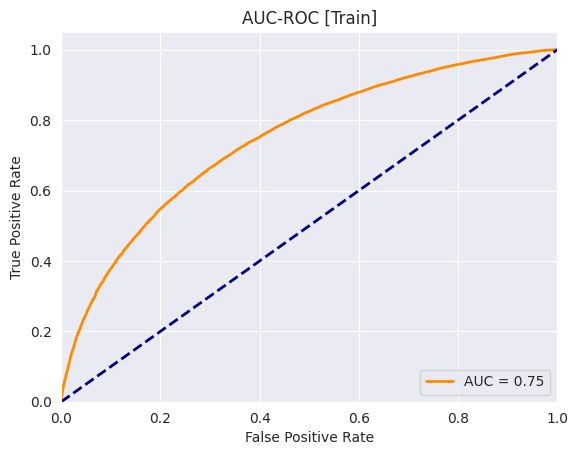

In [56]:
# Get the ROC curve
roc = rf_model.summary.roc.toPandas()

# Plot the ROC curve with AUC in the label
import matplotlib.pyplot as plt
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label=f'AUC = {areaUnderROC_train:.2f}')  # Use areaUnderROC here
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC [Train]')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [57]:
# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Evaluate the model's performance
evaluator = BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction")
areaUnderROC = evaluator.evaluate(predictions)
print("Area Under ROC = %f" % areaUnderROC)

Area Under ROC = 0.732960


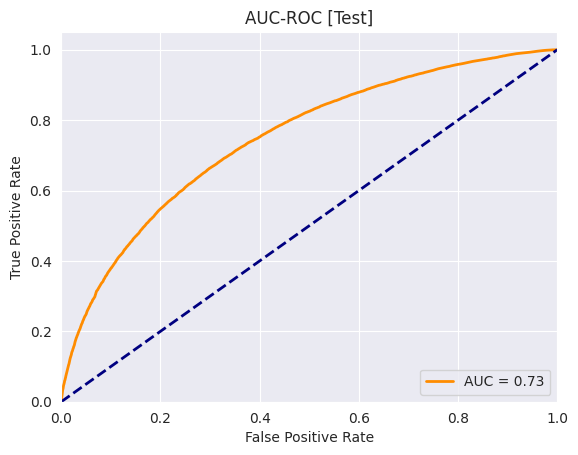

In [58]:
# Get the ROC curve
roc = rf_model.summary.roc.toPandas()

# Plot the ROC curve with AUC in the label
import matplotlib.pyplot as plt
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label=f'AUC = {areaUnderROC:.2f}')  # Use areaUnderROC here
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC [Test]')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [59]:
# Get the feature importances from the trained model
feature_importance = rf_model.featureImportances

# Define a list of feature column names
feature_cols = numerical_columns + [col + "_onehot" for col in categorical_columns]

# Create a list of (feature_name, importance) tuples
feature_importance_list = [(feature_cols[i], feature_importance[i]) for i in range(len(feature_cols))]

# Sort the list by feature importance in descending order
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: -x[1])

# Print the sorted feature importance
print("Feature Importance:\n")
for feat, importance in sorted_feature_importance:
    print(f"{feat}: {importance}")

Feature Importance:

Age: 0.33102885173342955
InterestRate: 0.22976060832618975
Income: 0.17532751490019707
LoanAmount: 0.10057948305470023
MonthsEmployed: 0.10016283783573451
CreditScore: 0.006059105536084632
HasDependents_onehot: 0.003829888525501987
NumCreditLines: 0.0025838854347292185
DTIRatio: 0.0017427439272296838
Education_onehot: 0.0005528671041848305
HasMortgage_onehot: 0.00036884059976589434
MaritalStatus_onehot: 0.0002936275800788386
LoanTerm: 0.00013470172206093444
EmploymentType_onehot: 8.640202412767974e-05
LoanPurpose_onehot: 5.823448725605328e-05
HasCoSigner_onehot: 3.719074661696379e-05


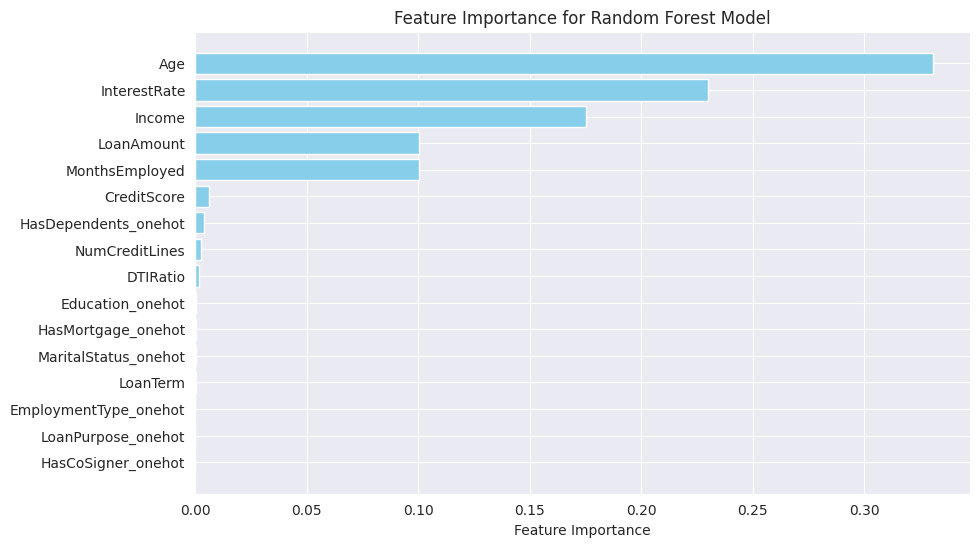

In [60]:
# Extract feature names and importances
feature_names, importances = zip(*sorted_feature_importance)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()  # Invert the y-axis for a top-down view

# Show the plot
plt.show()

### **Hyperparameter tuning and Cross-validation on the Random Forest model**

In [61]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

selected_features= ['Age','InterestRate', 'Income',  'MonthsEmployed',  'LoanAmount', 'CreditScore', 'HasDependents_onehot', 'NumCreditLines', 'DTIRatio', 'Education_onehot']
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Define a Random Forest model
rf = RandomForestClassifier(labelCol="Default", featuresCol="features")

# Create a parameter grid to search for the best hyperparameters
param_grid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 7, 10])  # Specify values to test for maxDepth
             .addGrid(rf.numTrees, [100, 200, 250])  # Specify values to test for numTrees
             .build())

# Create a cross-validator
cross_val = CrossValidator(estimator=rf,
                           estimatorParamMaps=param_grid,
                           evaluator=BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction"),
                           numFolds=5)  # Number of folds for cross-validation

# Fit the cross-validator to the training data
cv_model = cross_val.fit(train_data)

# Make predictions on the test data using the best model
best_rf_model = cv_model.bestModel
best_predictions = best_rf_model.transform(test_data)

# Evaluate the best model's performance
best_auc_roc = BinaryClassificationEvaluator(labelCol="Default", rawPredictionCol="rawPrediction").evaluate(best_predictions)
print("Best Model AUC-ROC: {:.4f}".format(best_auc_roc))


Best Model AUC-ROC: 0.7441


In [62]:
# Retrieve the best Random Forest model from the cross-validator
best_rf_model = cv_model.bestModel

# Get the best values for specific hyperparameters
best_maxDepth = best_rf_model.getMaxDepth()
best_numTrees = best_rf_model.getNumTrees

# Print the best hyperparameter values
print("Best maxDepth: {}".format(best_maxDepth))
print("Best numTrees: {}".format(best_numTrees))


Best maxDepth: 10
Best numTrees: 200


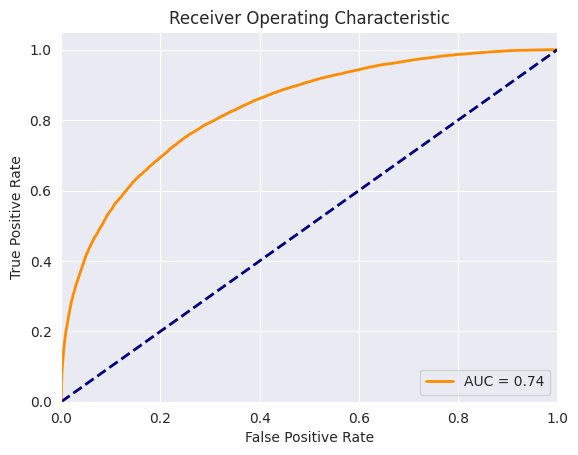

In [63]:
# Get the ROC curve
roc = cv_model.bestModel.summary.roc.toPandas()

# Plot the ROC curve
plt.plot(roc['FPR'], roc['TPR'], color='darkorange', lw=2, label=f'AUC = {best_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


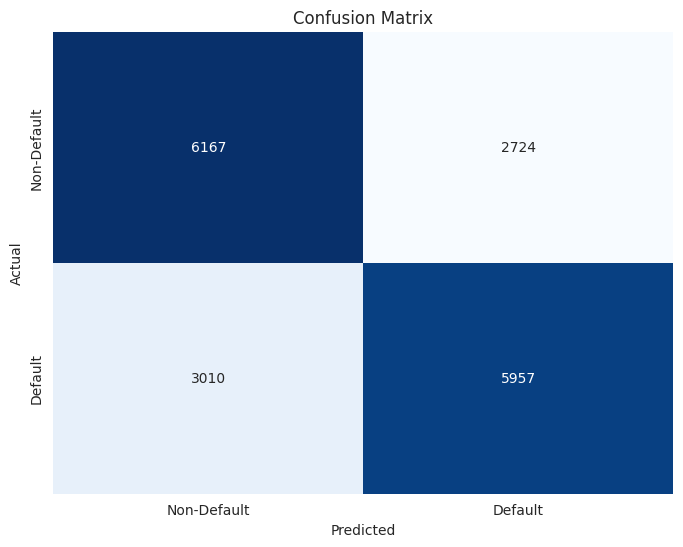


Accuracy: 0.67

Precision: 0.67

Recall: 0.67

F1-Score: 0.67


In [64]:
# Evaluate the model

from sklearn.metrics import confusion_matrix
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Get the confusion matrix
y_true = best_predictions.select("Default").rdd.flatMap(lambda x: x)
y_pred = best_predictions.select("prediction").rdd.flatMap(lambda x: x)
confusion_matrix = confusion_matrix(y_true.collect(), y_pred.collect())

# Add row and column names to the confusion matrix
class_names = ['Non-Default', 'Default']
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

"""
# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix_df)

"""

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Default", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy, precision, recall,and F1-score
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

"""
print("\nAccuracy:", accuracy)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nF1-Score:", f1_score)
"""

print(f"\nAccuracy: {accuracy:.2f}")
print(f"\nPrecision: {precision:.2f}")
print(f"\nRecall: {recall:.2f}")
print(f"\nF1-Score: {f1_score:.2f}")

In [65]:
sc.stop()

In [66]:
spark.sparkContext.stop()